In [24]:
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
import scipy.optimize
from scipy.optimize import minimize
import sys
import qgm
from qgm import image, parameter, filter, data, fitting, function
from regions import PixCoord, RectanglePixelRegion, CirclePixelRegion
cmap = image.generate_cmap(['#330000', 'r', 'w'])

In [25]:
distance_list = [50, 475, 600]
w0x_list = []
err_w0x_list = []
w0y_list = []
err_w0y_list = []

# Distance from laser head =50mm

In [26]:
date = '20220921_RepumpLDReplacement'
dataNo = 12

In [27]:
path = r"./"+date
path_img = path + r"/Data" + str('%03d' % dataNo) + ".txt"
header_index = 7
header = pd.read_csv(path_img, index_col=0, nrows=header_index)
raw_img_data = pd.read_csv(path_img, header=None, skiprows=np.arange(header_index+1), sep=';',engine='python')
raw_img_data = raw_img_data.drop(np.shape(raw_img_data)[1]-1,axis=1)
sample_img = np.array(raw_img_data)

In [28]:
magnification = 1
CCD_pixel_size = 5.5 #[um]
binning = 1
d = CCD_pixel_size*binning/magnification

In [29]:
pos_x=np.linspace(0, d*(np.shape(sample_img)[1]-1), np.shape(sample_img)[1])
pos_y=np.linspace(0, d*(np.shape(sample_img)[0]-1), np.shape(sample_img)[0])
mesh_x, mesh_y =np.meshgrid(pos_x,pos_y)

fitParameter_0=1.516767312774789e-07(3.110597825413051e-10)
fitParameter_1=5624.552777330055(1.01024091257195)
fitParameter_2=852.2548537092512(2.083435128540131)
fitParameter_3=0.0004073821412553236(4.0852533478789044e-07)


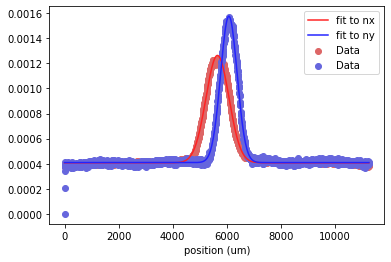

In [30]:
# x_list =np.arange(np.shape(sample_img)[1])
# x_list_2 =np.arange(np.shape(sample_img)[0])
x_list = pos_x
x_list_2 = pos_y
nx=np.sum(sample_img, axis=0)/np.sum(sample_img)
ny=np.sum(sample_img, axis=1)/np.sum(sample_img)
CoMy = []
CoMx = []

for i in range(len(nx)):
    CoMx += [i*nx[i]]
for i in range(len(ny)):
    CoMy += [i*ny[i]]
CoMx = np.sum(CoMx)
CoMy = np.sum(CoMy)

def gaussian_1d(x,*fit_param):
    return fit_param[0]*x*np.exp(-2*(x-fit_param[1])**2/fit_param[2]**2)+fit_param[3]

def fit_result(fit_func, x_data_list, y_data_list, initial_param_list, yerr=None):
    if (yerr is None):
        param, cov = scipy.optimize.curve_fit(fit_func, x_data_list, y_data_list, p0 = initial_param_list)
    else:
        param, cov = scipy.optimize.curve_fit(fit_func, x_data_list, y_data_list, p0 = initial_param_list, sigma=yerr)
    perr = np.sqrt(np.diag(cov))
    x_fit_list = np.linspace(np.min(x_data_list),np.max(x_data_list),400)
    y_fit_list = []
    for num in x_fit_list:
        y_fit_list.append(fit_func(num, *param))
    return param, perr, x_fit_list, y_fit_list

# para_ini=[np.max(nx), 170, 10, np.mean(nx[0:5])]
para_ini=[np.max(nx), 5000, 200, np.mean(nx[0:5])]
fitResultsOfSampleImage_list = fit_result(gaussian_1d, x_list, nx, para_ini)

for i in range(len(para_ini)):
    print("fitParameter_"+str(i)+"="+str(fitResultsOfSampleImage_list[0][i])+"("+str(fitResultsOfSampleImage_list[1][i])+")")

# para_ini=[np.max(nx), 130, 10, np.mean(nx[0:5])]
para_ini=[np.max(ny), 6000, 200, np.mean(ny[0:5])]
fitResultsOfSampleImage_list_2 = fit_result(gaussian_1d, x_list_2, ny, para_ini)

plt.scatter(x_list,nx, label='Data',c="#dd6666")
plt.plot(fitResultsOfSampleImage_list[2],fitResultsOfSampleImage_list[3],c="#ff2222",label="fit to nx")
plt.scatter(x_list_2,ny, label='Data',c="#6666dd")
plt.plot(fitResultsOfSampleImage_list_2[2],fitResultsOfSampleImage_list_2[3],c='#2222ff',label="fit to ny")
plt.xlabel('position (um)')

plt.legend()

In [31]:
w0_x = fitResultsOfSampleImage_list[0][2]
err_w0_x = fitResultsOfSampleImage_list[1][2]
print("w0_x = %.03f(%.03f) [um]"%(w0_x, err_w0_x))

w0_y = fitResultsOfSampleImage_list_2[0][2]
err_w0_y = fitResultsOfSampleImage_list_2[1][2]
print("w0_y = %.03f(%.03f) [um]"%(w0_y, err_w0_y))

w0_x = 852.255(2.083) [um]
w0_y = 610.969(1.549) [um]


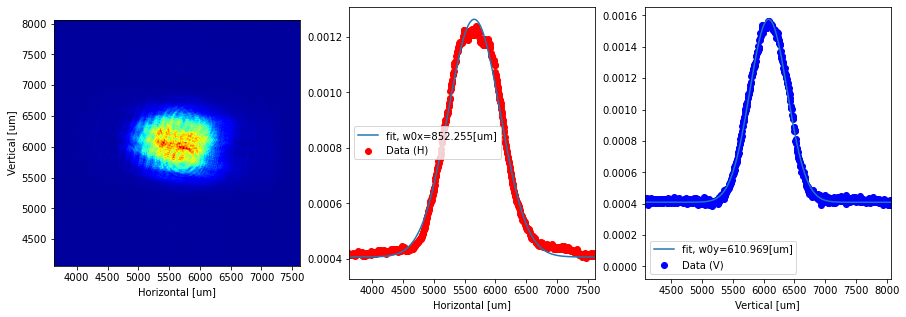

In [32]:
vmin = np.min(sample_img)
vmax = np.max(sample_img)
roi_x_width = 2000
roi_y_width = 2000
roi_x_center = fitResultsOfSampleImage_list[0][1]
roi_y_center = fitResultsOfSampleImage_list_2[0][1]
xlim_1 = roi_x_center - roi_x_width  
xlim_2 = roi_x_center + roi_x_width
ylim_1 = roi_y_center - roi_y_width
ylim_2 = roi_y_center + roi_y_width

fig =plt.figure(figsize=[15,5])
ax1 = fig.add_subplot(1,3,1)
mappable =ax1.pcolormesh(mesh_x,mesh_y,sample_img, vmin=vmin, vmax=vmax, shading='auto',cmap = 'jet')
ax1.set_aspect('equal')
ax1.set_xlim(xlim_1,xlim_2)
ax1.set_ylim(ylim_1,ylim_2)
ax1.set_xlabel('Horizontal [um]')
ax1.set_ylabel('Vertical [um]')

ax2 = fig.add_subplot(1,3,2)
ax2.scatter(x_list,nx, label='Data (H)',c="r")
ax2.plot(fitResultsOfSampleImage_list[2],fitResultsOfSampleImage_list[3],label="fit, w0x=%.03f[um]"%(w0_x))
ax2.set_xlim(xlim_1,xlim_2)
ax2.set_xlabel('Horizontal [um]')
ax2.legend()

ax3 = fig.add_subplot(1,3,3)
ax3.scatter(x_list_2,ny, label='Data (V)',c="b")
ax3.plot(fitResultsOfSampleImage_list_2[2],fitResultsOfSampleImage_list_2[3],label="fit, w0y=%.03f[um]"%(w0_y))
ax3.set_xlim(ylim_1,ylim_2)
ax3.set_xlabel('Vertical [um]')
ax3.legend()

In [33]:
w0x_list.append(w0_x)
err_w0x_list.append(err_w0_x)
w0y_list.append(w0_y)
err_w0y_list.append(err_w0_y)

# Distance from laser head =475mm

In [34]:
dataNo = 13
path = r"./"+date
path_img = path + r"/Data" + str('%03d' % dataNo) + ".txt"
header_index = 7
header = pd.read_csv(path_img, index_col=0, nrows=header_index)
raw_img_data = pd.read_csv(path_img, header=None, skiprows=np.arange(header_index+1), sep=';',engine='python')
raw_img_data = raw_img_data.drop(np.shape(raw_img_data)[1]-1,axis=1)
sample_img = np.array(raw_img_data)

fitParameter_0=1.8764485917990705e-07(5.697556355322643e-10)
fitParameter_1=5619.174953708164(1.709524986923772)
fitParameter_2=971.9701613647741(3.5392479201984486)
fitParameter_3=0.0003742485376859356(8.109105996724763e-07)


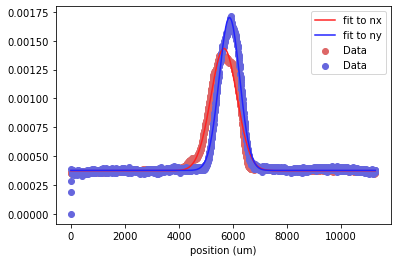

In [35]:
pos_x=np.linspace(0, d*(np.shape(sample_img)[1]-1), np.shape(sample_img)[1])
pos_y=np.linspace(0, d*(np.shape(sample_img)[0]-1), np.shape(sample_img)[0])
mesh_x, mesh_y =np.meshgrid(pos_x,pos_y)

x_list = pos_x
x_list_2 = pos_y
nx=np.sum(sample_img, axis=0)/np.sum(sample_img)
ny=np.sum(sample_img, axis=1)/np.sum(sample_img)
CoMy = []
CoMx = []

for i in range(len(nx)):
    CoMx += [i*nx[i]]
for i in range(len(ny)):
    CoMy += [i*ny[i]]
CoMx = np.sum(CoMx)
CoMy = np.sum(CoMy)

para_ini=[np.max(nx), 5000, 200, np.mean(nx[0:5])]
fitResultsOfSampleImage_list = fit_result(gaussian_1d, x_list, nx, para_ini)

for i in range(len(para_ini)):
    print("fitParameter_"+str(i)+"="+str(fitResultsOfSampleImage_list[0][i])+"("+str(fitResultsOfSampleImage_list[1][i])+")")


para_ini=[np.max(ny), 6000, 200, np.mean(ny[0:5])]
fitResultsOfSampleImage_list_2 = fit_result(gaussian_1d, x_list_2, ny, para_ini)

plt.scatter(x_list,nx, label='Data',c="#dd6666")
plt.plot(fitResultsOfSampleImage_list[2],fitResultsOfSampleImage_list[3],c="#ff2222",label="fit to nx")
plt.scatter(x_list_2,ny, label='Data',c="#6666dd")
plt.plot(fitResultsOfSampleImage_list_2[2],fitResultsOfSampleImage_list_2[3],c='#2222ff',label="fit to ny")
plt.xlabel('position (um)')

plt.legend()

In [36]:
w0_x = fitResultsOfSampleImage_list[0][2]
err_w0_x = fitResultsOfSampleImage_list[1][2]
print("w0_x = %.03f(%.03f) [um]"%(w0_x, err_w0_x))

w0_y = fitResultsOfSampleImage_list_2[0][2]
err_w0_y = fitResultsOfSampleImage_list_2[1][2]
print("w0_y = %.03f(%.03f) [um]"%(w0_y, err_w0_y))

w0_x = 971.970(3.539) [um]
w0_y = 760.222(2.324) [um]


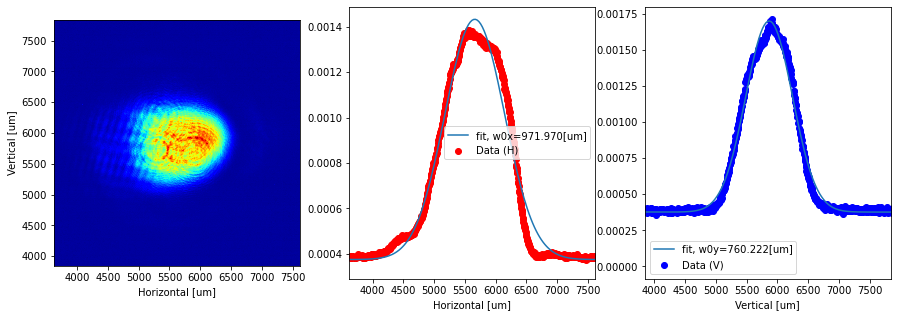

In [37]:
vmin = np.min(sample_img)
vmax = np.max(sample_img)
roi_x_width = 2000
roi_y_width = 2000
roi_x_center = fitResultsOfSampleImage_list[0][1]
roi_y_center = fitResultsOfSampleImage_list_2[0][1]
xlim_1 = roi_x_center - roi_x_width  
xlim_2 = roi_x_center + roi_x_width
ylim_1 = roi_y_center - roi_y_width
ylim_2 = roi_y_center + roi_y_width

fig =plt.figure(figsize=[15,5])
ax1 = fig.add_subplot(1,3,1)
mappable =ax1.pcolormesh(mesh_x,mesh_y,sample_img, vmin=vmin, vmax=vmax, shading='auto',cmap = 'jet')
ax1.set_aspect('equal')
ax1.set_xlim(xlim_1,xlim_2)
ax1.set_ylim(ylim_1,ylim_2)
ax1.set_xlabel('Horizontal [um]')
ax1.set_ylabel('Vertical [um]')

ax2 = fig.add_subplot(1,3,2)
ax2.scatter(x_list,nx, label='Data (H)',c="r")
ax2.plot(fitResultsOfSampleImage_list[2],fitResultsOfSampleImage_list[3],label="fit, w0x=%.03f[um]"%(w0_x))
ax2.set_xlim(xlim_1,xlim_2)
ax2.set_xlabel('Horizontal [um]')
ax2.legend()

ax3 = fig.add_subplot(1,3,3)
ax3.scatter(x_list_2,ny, label='Data (V)',c="b")
ax3.plot(fitResultsOfSampleImage_list_2[2],fitResultsOfSampleImage_list_2[3],label="fit, w0y=%.03f[um]"%(w0_y))
ax3.set_xlim(ylim_1,ylim_2)
ax3.set_xlabel('Vertical [um]')
ax3.legend()

In [38]:
w0x_list.append(w0_x)
err_w0x_list.append(err_w0_x)
w0y_list.append(w0_y)
err_w0y_list.append(err_w0_y)

# Distance from laser head = 675mm

In [39]:
dataNo = 14
path = r"./"+date
path_img = path + r"/Data" + str('%03d' % dataNo) + ".txt"
header_index = 7
header = pd.read_csv(path_img, index_col=0, nrows=header_index)
raw_img_data = pd.read_csv(path_img, header=None, skiprows=np.arange(header_index+1), sep=';',engine='python')
raw_img_data = raw_img_data.drop(np.shape(raw_img_data)[1]-1,axis=1)
sample_img = np.array(raw_img_data)

fitParameter_0=1.5904364819332945e-07(5.271736252169256e-10)
fitParameter_1=6120.348337166636(1.9264814668648937)
fitParameter_2=1005.9444223573339(4.001275640063784)
fitParameter_3=0.0003793296146284879(8.350305754167285e-07)


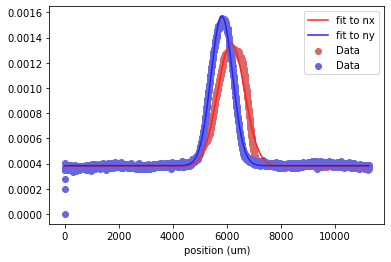

In [40]:
pos_x=np.linspace(0, d*(np.shape(sample_img)[1]-1), np.shape(sample_img)[1])
pos_y=np.linspace(0, d*(np.shape(sample_img)[0]-1), np.shape(sample_img)[0])
mesh_x, mesh_y =np.meshgrid(pos_x,pos_y)

x_list = pos_x
x_list_2 = pos_y
nx=np.sum(sample_img, axis=0)/np.sum(sample_img)
ny=np.sum(sample_img, axis=1)/np.sum(sample_img)
CoMy = []
CoMx = []

for i in range(len(nx)):
    CoMx += [i*nx[i]]
for i in range(len(ny)):
    CoMy += [i*ny[i]]
CoMx = np.sum(CoMx)
CoMy = np.sum(CoMy)

para_ini=[np.max(nx), 6000, 200, np.mean(nx[0:5])]
fitResultsOfSampleImage_list = fit_result(gaussian_1d, x_list, nx, para_ini)

for i in range(len(para_ini)):
    print("fitParameter_"+str(i)+"="+str(fitResultsOfSampleImage_list[0][i])+"("+str(fitResultsOfSampleImage_list[1][i])+")")


para_ini=[np.max(ny), 6000, 200, np.mean(ny[0:5])]
fitResultsOfSampleImage_list_2 = fit_result(gaussian_1d, x_list_2, ny, para_ini)

plt.scatter(x_list,nx, label='Data',c="#dd6666")
plt.plot(fitResultsOfSampleImage_list[2],fitResultsOfSampleImage_list[3],c="#ff2222",label="fit to nx")
plt.scatter(x_list_2,ny, label='Data',c="#6666dd")
plt.plot(fitResultsOfSampleImage_list_2[2],fitResultsOfSampleImage_list_2[3],c='#2222ff',label="fit to ny")
plt.xlabel('position (um)')

plt.legend()

In [41]:
w0_x = fitResultsOfSampleImage_list[0][2]
err_w0_x = fitResultsOfSampleImage_list[1][2]
print("w0_x = %.03f(%.03f) [um]"%(w0_x, err_w0_x))

w0_y = fitResultsOfSampleImage_list_2[0][2]
err_w0_y = fitResultsOfSampleImage_list_2[1][2]
print("w0_y = %.03f(%.03f) [um]"%(w0_y, err_w0_y))

w0_x = 1005.944(4.001) [um]
w0_y = 801.811(1.881) [um]


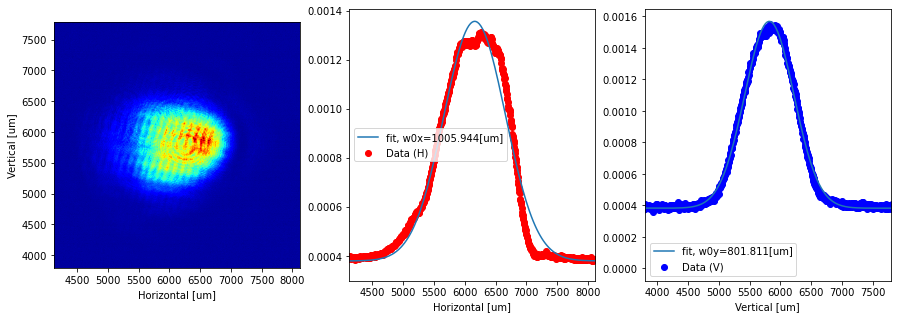

In [42]:
vmin = np.min(sample_img)
vmax = np.max(sample_img)
roi_x_width = 2000
roi_y_width = 2000
roi_x_center = fitResultsOfSampleImage_list[0][1]
roi_y_center = fitResultsOfSampleImage_list_2[0][1]
xlim_1 = roi_x_center - roi_x_width  
xlim_2 = roi_x_center + roi_x_width
ylim_1 = roi_y_center - roi_y_width
ylim_2 = roi_y_center + roi_y_width

fig =plt.figure(figsize=[15,5])
ax1 = fig.add_subplot(1,3,1)
mappable =ax1.pcolormesh(mesh_x,mesh_y,sample_img, vmin=vmin, vmax=vmax, shading='auto',cmap = 'jet')
ax1.set_aspect('equal')
ax1.set_xlim(xlim_1,xlim_2)
ax1.set_ylim(ylim_1,ylim_2)
ax1.set_xlabel('Horizontal [um]')
ax1.set_ylabel('Vertical [um]')

ax2 = fig.add_subplot(1,3,2)
ax2.scatter(x_list,nx, label='Data (H)',c="r")
ax2.plot(fitResultsOfSampleImage_list[2],fitResultsOfSampleImage_list[3],label="fit, w0x=%.03f[um]"%(w0_x))
ax2.set_xlim(xlim_1,xlim_2)
ax2.set_xlabel('Horizontal [um]')
ax2.legend()

ax3 = fig.add_subplot(1,3,3)
ax3.scatter(x_list_2,ny, label='Data (V)',c="b")
ax3.plot(fitResultsOfSampleImage_list_2[2],fitResultsOfSampleImage_list_2[3],label="fit, w0y=%.03f[um]"%(w0_y))
ax3.set_xlim(ylim_1,ylim_2)
ax3.set_xlabel('Vertical [um]')
ax3.legend()

In [43]:
w0x_list.append(w0_x)
err_w0x_list.append(err_w0_x)
w0y_list.append(w0_y)
err_w0y_list.append(err_w0_y)

# Beam trace

In [44]:
wavelength = 780*1e-6 #[mm]

In [45]:
distance_list = np.array(distance_list)
w0x_list = np.array(w0x_list)*1e-3 #[mm]
err_w0x_list = np.array(err_w0x_list)*1e-3
w0y_list = np.array(w0y_list)*1e-3
err_w0y_list = np.array(err_w0y_list)*1e-3

fitParameter_0=0.637145574139974(0.005002876421612277)
fitParameter_1=-1403.0496397887787(3.71617395652848)


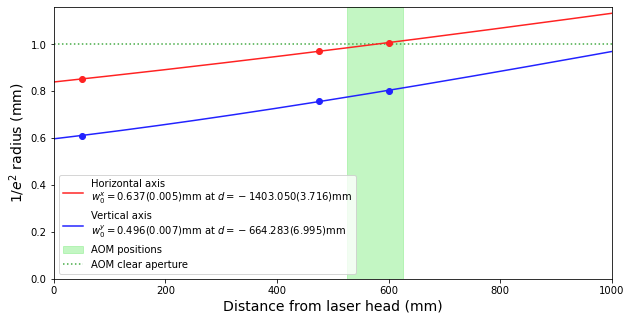

In [46]:
def quadratic_function(x,*fit_param):
    return fit_param[0]*np.sqrt(1+(x-fit_param[1])**2/(np.pi*fit_param[0]**2/wavelength)**2)
para_ini = [1, 0]
fitReslutsBeamTrace_x_list = fit_result(quadratic_function, distance_list, w0x_list, para_ini, err_w0x_list)
fitReslutsBeamTrace_y_list = fit_result(quadratic_function, distance_list, w0y_list, para_ini, err_w0y_list)

for i in range(len(para_ini)):
    print("fitParameter_"+str(i)+"="+str(fitReslutsBeamTrace_x_list[0][i])+"("+str(fitReslutsBeamTrace_x_list[1][i])+")")

def beamTraceFitResult(fit_func, param, start, stop):
    x_fit_list = np.linspace(start, stop, 200)
    y_fit_list = []
    for num in x_fit_list:
        y_fit_list.append(fit_func(num, *param))
    return x_fit_list, y_fit_list

fit_h_list = beamTraceFitResult(quadratic_function, fitReslutsBeamTrace_x_list[0], 0, 1000)
fit_v_list = beamTraceFitResult(quadratic_function, fitReslutsBeamTrace_y_list[0], 0, 1000)

xmin=0
xmax=1000
fig = plt.figure(figsize=[10,5])
plt.plot(fit_h_list[0],fit_h_list[1],c="#ff2222",label="Horizontal axis"+"\n"+r"$w_0^x=%.03f(%.03f) $mm at $d=%.03f(%.03f)$mm"%(fitReslutsBeamTrace_x_list[0][0], fitReslutsBeamTrace_x_list[1][0], fitReslutsBeamTrace_x_list[0][1], fitReslutsBeamTrace_x_list[1][1]))
plt.errorbar(distance_list, w0x_list, err_w0x_list, fmt='o',c="#ff2222")
plt.plot(fit_v_list[0],fit_v_list[1],c="#2222ff",label="Vertical axis"+"\n"+r"$w_0^y=%.03f(%.03f) $mm at $d=%.03f(%.03f)$mm"%(fitReslutsBeamTrace_y_list[0][0], fitReslutsBeamTrace_y_list[1][0], fitReslutsBeamTrace_y_list[0][1], fitReslutsBeamTrace_y_list[1][1]))
plt.errorbar(distance_list, w0y_list, err_w0y_list, fmt='o',c="#2222ff")
plt.hlines(y=1, xmin=xmin, xmax=xmax, linestyles=':', colors="#44aa44", label="AOM clear aperture")
plt.axvspan(xmin=525, xmax=625, alpha=0.5, color="#88ee88", label="AOM positions")
plt.xlim(0, xmax)
plt.ylim(0,)
plt.xlabel('Distance from laser head (mm)', fontsize = 14)
plt.ylabel(r'$1/e^2$ radius (mm)', fontsize = 14)
plt.legend()